In [2]:
%load_ext autoreload
%autoreload 2

from setup_imports import *  # noqa: F401,F403
from src.phrases.utils import generate_phrase_hash
from src.wiktionary.lookup import get_wiktionary_urls
import json
from src.phrases.search import (
    get_phrase,
    get_phrases_by_collection,
    get_verbs_from_phrases,
    get_vocab_from_phrases,
)
from src.story import get_story
from src.challenges.models import ChallengeRecord, get_challenge
from langcodes import Language
from src.anki_tools import create_anki_deck

In [3]:
p = get_phrase("a_still_water_f12151")

(y) Authenticated with Google Cloud project: swedish-course


In [10]:
p.download(local=False)

2026-02-01 17:27:57 - audio-language-trainer - INFO - phrase_model.py:402 - Downloading multimedia for phrase a_still_water_f12151 - all translations
2026-02-01 17:27:57 - audio-language-trainer - INFO - phrase_model.py:964 - Downloading all multimedia for de-DE translation


2026-02-01 17:27:57 - audio-language-trainer - INFO - phrase_model.py:819 - Downloading audio: de-DE flashcard/normal from phrases/de-DE/audio/flashcard/normal/a_still_water_f12151.mp3 (without local cache)
2026-02-01 17:27:57 - audio-language-trainer - INFO - phrase_model.py:819 - Downloading audio: de-DE flashcard/slow from phrases/de-DE/audio/flashcard/slow/a_still_water_f12151.mp3 (without local cache)
2026-02-01 17:27:57 - audio-language-trainer - INFO - phrase_model.py:1077 - Downloading image: de-DE from phrases/en-GB/images/a_still_water_f12151.png (without local cache)
2026-02-01 17:27:58 - audio-language-trainer - INFO - phrase_model.py:964 - Downloading all multimedia for en-GB translation
2026-02-01 17:27:58 - audio-language-trainer - INFO - phrase_model.py:1077 - Downloading image: en-GB from phrases/en-GB/images/a_still_water_f12151.png (without local cache)
2026-02-01 17:27:58 - audio-language-trainer - INFO - phrase_model.py:964 - Downloading all multimedia for sv-SE tr

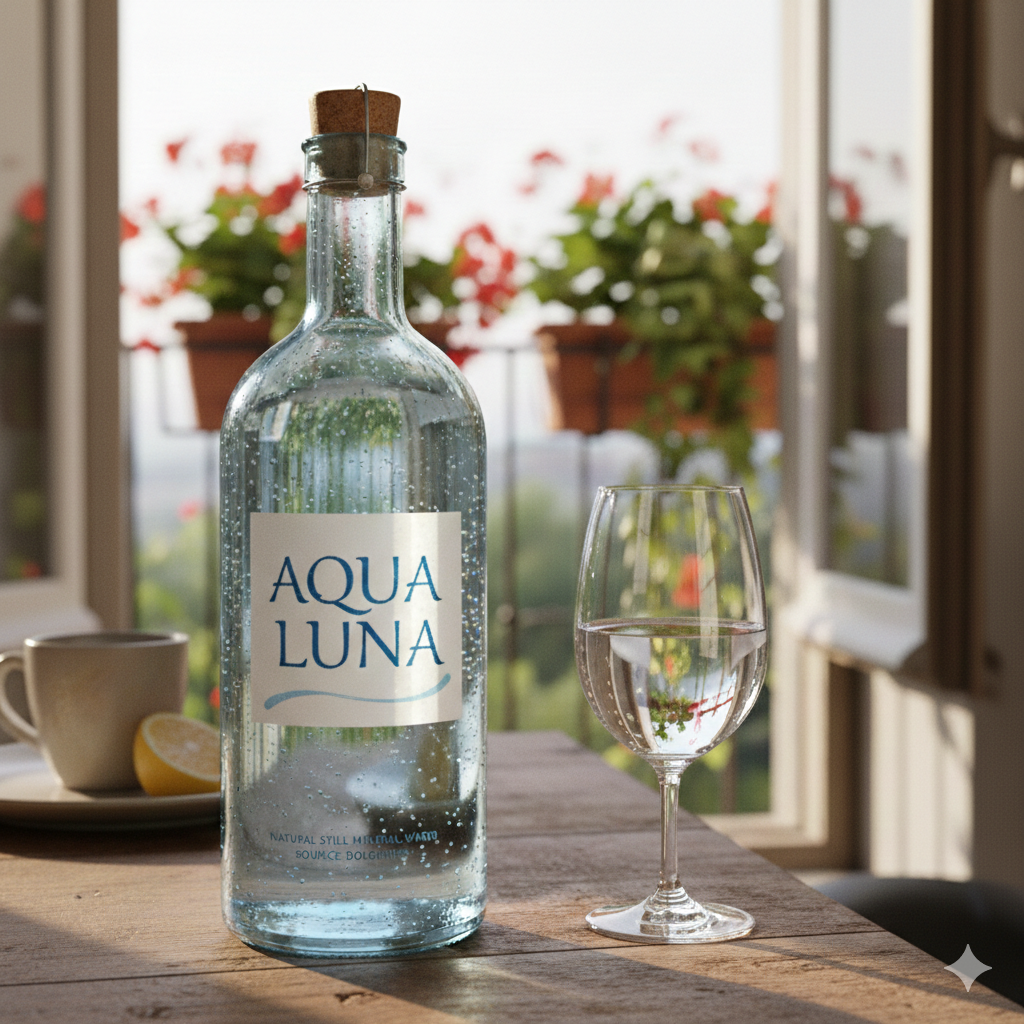

In [11]:
p.get_image(local=True)

In [ ]:
p.translate("en-GB", overwrite=True)

p.upload(overwrite=True)

2026-01-31 21:11:14 - audio-language-trainer - INFO - phrase_model.py:367 - Uploading phrase plants_photosynthesize_using_sunlight_fdc063 with all translations to Firestore and GCS
2026-01-31 21:11:15 - audio-language-trainer - INFO - phrase_model.py:1003 - Uploading all multimedia for en-GB translation
2026-01-31 21:11:15 - audio-language-trainer - INFO - phrase_model.py:1003 - Uploading all multimedia for uk-UA translation


In [11]:
p.generate_audio(language="en-GB", context="flashcard", overwrite=True)
p.upload(overwrite=True)

(y) Google Text-to-Speech API client initialized
2026-01-31 21:17:19 - audio-language-trainer - INFO - phrase_model.py:367 - Uploading phrase plants_photosynthesize_using_sunlight_fdc063 with all translations to Firestore and GCS
2026-01-31 21:17:19 - audio-language-trainer - INFO - phrase_model.py:1003 - Uploading all multimedia for en-GB translation
2026-01-31 21:17:19 - audio-language-trainer - INFO - phrase_model.py:783 - Uploading audio: en-GB flashcard/normal to phrases/en-GB/audio/flashcard/normal/plants_photosynthesize_using_sunlight_fdc063.mp3 (local cache enabled)
2026-01-31 21:17:20 - audio-language-trainer - INFO - phrase_model.py:783 - Uploading audio: en-GB flashcard/slow to phrases/en-GB/audio/flashcard/slow/plants_photosynthesize_using_sunlight_fdc063.mp3 (local cache enabled)
2026-01-31 21:17:20 - audio-language-trainer - INFO - phrase_model.py:1060 - Uploading image: en-GB to phrases/en-GB/images/plants_photosynthesize_using_sunlight_fdc063.png (local cache enabled)
2

In [12]:
aud = p.get_audio(language="en-GB", context="flashcard")

In [ ]:
create_anki_deck(
    [p],
    source_language="uk-UA",
    target_language="en-GB",
    deck_name="Test Deck",
    output_path="../outputs/decks/test_deck.apkg",
)

2026-01-31 21:17:29 - audio-language-trainer - INFO - anki_tools.py:341 - Creating Anki deck: Test Deck
2026-01-31 21:17:29 - audio-language-trainer - INFO - anki_tools.py:342 - Source language: uk-UA
2026-01-31 21:17:29 - audio-language-trainer - INFO - anki_tools.py:343 - Target language: en-GB
2026-01-31 21:17:29 - audio-language-trainer - INFO - anki_tools.py:344 - Processing 1 phrases...


Creating notes:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-31 21:17:29 - audio-language-trainer - INFO - phrase_model.py:398 - Downloading multimedia for phrase plants_photosynthesize_using_sunlight_fdc063 - en-GB translation only


2026-01-31 21:17:29 - audio-language-trainer - INFO - phrase_model.py:964 - Downloading all multimedia for en-GB translation
2026-01-31 21:17:29 - audio-language-trainer - INFO - phrase_model.py:819 - Downloading audio: en-GB flashcard/normal from phrases/en-GB/audio/flashcard/normal/plants_photosynthesize_using_sunlight_fdc063.mp3 (with local cache)
2026-01-31 21:17:29 - audio-language-trainer - INFO - phrase_model.py:819 - Downloading audio: en-GB flashcard/slow from phrases/en-GB/audio/flashcard/slow/plants_photosynthesize_using_sunlight_fdc063.mp3 (with local cache)
2026-01-31 21:17:29 - audio-language-trainer - INFO - phrase_model.py:1077 - Downloading image: en-GB from phrases/en-GB/images/plants_photosynthesize_using_sunlight_fdc063.png (with local cache)


Adding notes to deck: 100%|██████████| 1/1 [00:00<?, ?it/s]

2026-01-31 21:17:29 - audio-language-trainer - INFO - anki_tools.py:376 - (y) Created deck with 1 notes
2026-01-31 21:17:29 - audio-language-trainer - INFO - anki_tools.py:382 - Saved Anki Deck to ../outputs/decks/test_deck.apkg


: 

In [ ]:
target_lang = Language.get("sv-SE")
print(target_lang.display_name())

In [ ]:
story.publish_story(target_language=target_lang)

In [ ]:
challenge = get_challenge(story_title_hash="a_winter_morning_walk_d7b5b3")

In [ ]:
challenge.publish(target_language=target_lang, overwrite=True)

In [ ]:
story = get_story(story_title_hash="flying_to_suprise_the_family_9bb91e")

In [ ]:
story.publish_story(target_language="sv-SE", overwrite=True)

In [ ]:
challenge = ChallengeRecord.create(story)

In [ ]:
challenge.upload()

In [ ]:
challenge.publish(target_language="sv-SE", overwrite=True)

In [ ]:
challenge.model_dump()

In [ ]:
Challenge.model_validate(challenge)

In [ ]:
"""Test script to render a challenge HTML from your example challenge data."""


# Your example challenge data
challenge_data = {
    "scenarios": [
        {
            "role_learner": "person going for a walk",
            "role_teacher": "walking companion",
            "situation": "Two friends preparing to go for a winter walk outside their home",
            "difficulty": "easy",
            "task": "Get ready for the walk and find out what to bring",
            "find_out": [
                {
                    "question": "What clothing items should be worn?",
                    "answer": "Blue jeans and a hat",
                },
                {"question": "What drink should be brought along?", "answer": "Coffee"},
                {
                    "question": "What should be done before leaving?",
                    "answer": "Check how cold it is by opening the window",
                },
            ],
        },
        {
            "role_learner": "lost walker in the park",
            "role_teacher": "walking companion",
            "situation": "Two people walking in a snowy park who realize they might be lost",
            "difficulty": "medium",
            "task": "Recognize you're lost and figure out how to get help",
            "find_out": [
                {
                    "question": "Does your companion think you're going the wrong way?",
                    "answer": "Yes, they don't recognize this part of the park",
                },
                {
                    "question": "What solution does your companion suggest?",
                    "answer": "Ask someone for directions",
                },
                {
                    "question": "Where should you wait while they ask?",
                    "answer": "Wait here while they talk to the person",
                },
            ],
        },
        {
            "role_learner": "person receiving directions",
            "role_teacher": "walking companion who just got directions",
            "situation": "In a park after getting lost, your companion has just returned with directions from a helpful stranger",
            "difficulty": "hard",
            "task": "Find out the directions and confirm you understand the way home",
            "find_out": [
                {
                    "question": "What are the directions to get back?",
                    "answer": "Go straight and then turn right at the large store",
                },
                {
                    "question": "Why do you recognize the location now?",
                    "answer": "The store is memorable and means we're close to home",
                },
                {
                    "question": "What would you like to do before going home?",
                    "answer": "Drink the coffee together because it's cold",
                },
            ],
        },
    ]
}

# Template context
context = {
    "title": "A Winter Morning Walk",
    "target_language": "Swedish",
    "target_language_code": "sv-SE",
    "source_language": "British English",
    "source_language_code": "en-GB",
    "scenarios": challenge_data["scenarios"],
}

from src.utils import render_html_content


html_content = render_html_content(context, "challenge_template.html")
with open("../outputs/test.html", "w", encoding="utf-8") as f:
    f.write(html_content)

In [ ]:
response.scenarios[2].find_out

In [ ]:
COLLECTION = "LM1000"
DECK = "Pack01"

phrases = get_phrases_by_collection(COLLECTION, DECK)

In [ ]:
p = phrases[0]
get_wiktionary_urls(p.translations["sr-RS"].tokens, "sr")

In [ ]:
len(get_vocab_from_phrases(phrases))

In [ ]:
get_verbs_from_phrases(phrases)

In [ ]:
text = "Measure the pH level"

In [ ]:
tokens = text.split(" ")

In [ ]:
_get_wiktionary_url

In [ ]:
get_wiktionary_url("pH", "pH", "en")

In [ ]:
with open(
    "../outputs/wiktionary_dump/wiktionary_dump.json", "r", encoding="utf-8"
) as f:
    for step, line in enumerate(f):
        data = json.loads(line)
        print(data)
        break

In [ ]:
"Sam! Har du sett det här offentliga meddelandet om allemansrätten? Det öppnas en ny vandringsled imorgon."

In [ ]:
story_title = "A Test Story"
story_summary = "A brief summary of the test story."
story_title_hash = generate_phrase_hash(story_title)
story_dialogue = load_json("../data/test_story.json")

story_title2 = "A Test Story 2"
story_summary2 = "A brief summary of the test story 2."
story_title_hash2 = generate_phrase_hash(story_title2)
story_dialogue2 = load_json("../data/test_story2.json")

In [ ]:
ts1 = Story.create(
    story_title, story_summary, story_dialogue, collection="Test", deck="Pack01"
)
ts2 = Story.create(
    story_title2, story_summary2, story_dialogue2, collection="Test2", deck="Pack01"
)
ts1.upload(overwrite=True)
ts2.upload(overwrite=True)